# 1. Setup

In [ ]:
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load Dataset/Gambar

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/playing_card_dataset/rank'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [ ]:
batch = 32
img_height = 125
img_width = 70

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch)

Found 2759 files belonging to 13 classes.
Using 2208 files for training.


In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch)

Found 2759 files belonging to 13 classes.
Using 551 files for validation.


In [ ]:
class_names = val_ds.class_names
print(class_names)

['10', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'J', 'K', 'Q']


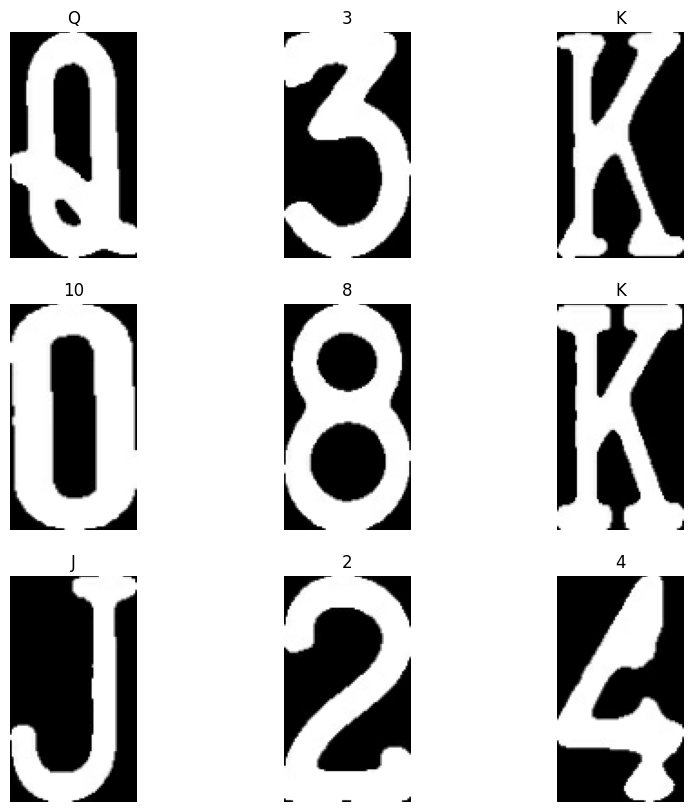

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 125, 70, 3)
(32,)


# 3. Tuning Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Menghasilkan Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
num_classes = len(class_names)

model = Sequential([
  #Mengubah rentang gambar dari 0 sampai 1
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #Layer Konvolusi
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Menyatukan Konvolusi
  layers.Flatten(),

  # Layer Dense
  layers.Dense(100, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile('adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 125, 70, 3)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 70, 64)       1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 35, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 62, 35, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 138880)            0         
                                                                 
 dense_2 (Dense)             (None, 100)               13888100  
                                                      

# 5. Training

In [ ]:
log_dir = '/content/drive/MyDrive/Colab Notebooks/training_logs/playing_card_log'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
hist = model.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 callbacks=[tensorboard_callback])

Epoch 1/10
69/69 [==============================] - 5s 18ms/step - loss: 0.1688 - accuracy: 0.9633 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/10
69/69 [==============================] - 1s 16ms/step - loss: 1.3150e-04 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/10
69/69 [==============================] - 1s 16ms/step - loss: 1.2536e-05 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/10
69/69 [==============================] - 1s 16ms/step - loss: 6.7522e-06 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
69/69 [==============================] - 1s 16ms/step - loss: 4.8702e-06 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/10
69/69 [==============================] - 1s 16ms/step - loss: 3.8091e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
69/69 [==============================] - 1s 16ms/step - loss: 2.9725e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accura

# 6. Plot Performa

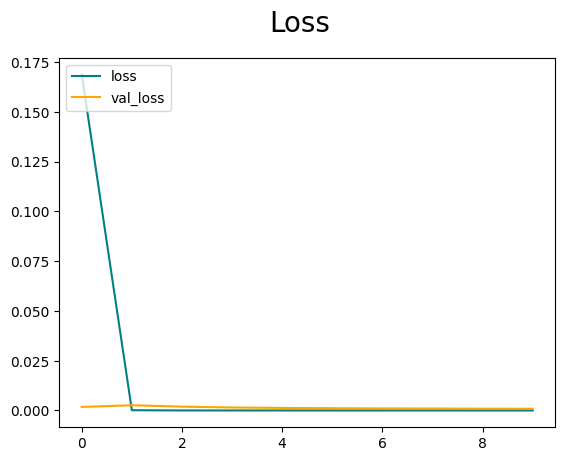

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

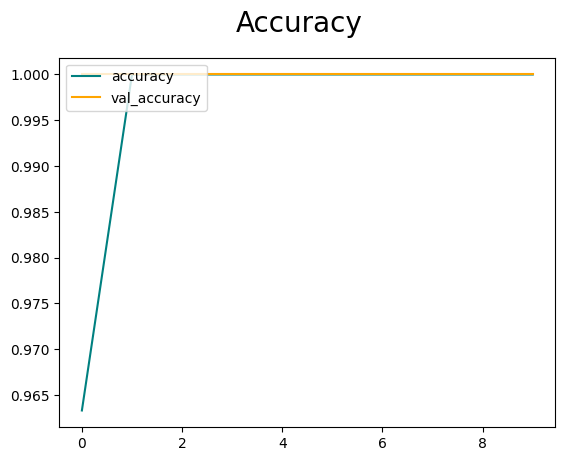

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 7. Testing

In [ ]:
img = tf.keras.utils.load_img('/content/drive/MyDrive/Colab Notebooks/J.jpg', target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [ ]:
prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])
print(score)

1/1 [==============================] - 0s 80ms/step
tf.Tensor(
[0.06794272 0.06794273 0.06794273 0.06794272 0.06794272 0.06794272
 0.06794276 0.06794272 0.06794272 0.06794272 0.18468721 0.06794275
 0.06794272], shape=(13,), dtype=float32)


In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to J with a 18.47 percent confidence.


# 8. Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/models/modelDeteksiKartu.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
